# Анализ влияния различных факторов на стоимость медицинской страховкию. Построение предиктивной модели.

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import scipy.stats as sts
from scipy import stats
import numpy as np

In [2]:
# Загружаем датасет
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Датасет имеет 7 столбцов:
- age - возраст
- sex - пол (женский или мужской)
- bmi (body mass index) - индекс массы тела
- children - количество детей
- smoker - курит или не курит человек
- region - регион (принимает четыре значения southwest, southeast, northwest, northeast)
- charges - стоимость страховки

In [4]:
# Посмотрим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Датасет не имеет пропущенных значений. В датасете представлено 1338 строк.

Рассмотрим кратко каждый столбец датасета.

Столбец age (возраст) - дискретная величина, принимает только целые значения.

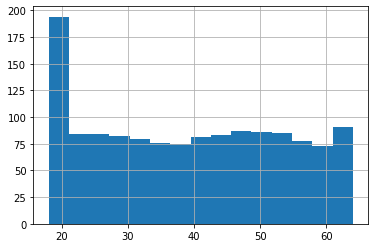

In [5]:
data.age.hist(bins = 15)

In [6]:
max(data.age), min(data.age)

(64, 18)

Диапазон значений от 18 до 64 лет. Причем в нашем датасете представлено много молодежи (18-20 лет).

Столбец sex (пол) - категориальные данные, принимают значение либо male - мужчина, либо female - женщина.

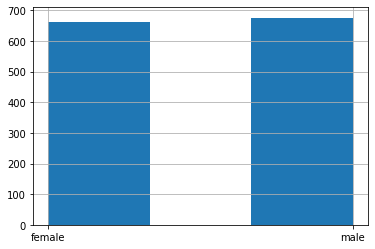

In [7]:
data.sex.hist(bins=3)

Переменная sex имеет биномиальное рапределение. 

In [8]:
len(data[data['sex'] == 'male']), len(data[data['sex'] == 'female'])

(676, 662)

По количеству мужчин 676, женщин 662.

Столбец bmi - непрерывная величина.

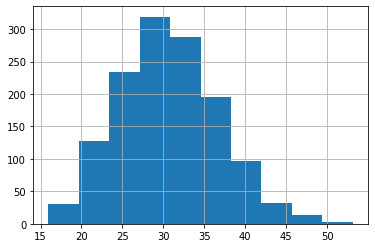

In [9]:
data.bmi.hist()

Проверим, является ли распределение bmi нормальным. Применим тест Шапиро-Вилка. Данный тест проверяет, имеет ли выборка данных распределение Гаусса. 

- Гипотеза H0 - образец имеет нормальное гауссово распределение
- Гипотеза H1 - образец не имеет нормальное распределение

In [10]:
from scipy.stats import shapiro
alpha = 0.05
stat, p = shapiro(data['bmi'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > alpha:
# 
    print('Гауссово рапределение')
else:
    print('Распределение не является нормальным')

stat=0.994, p=0.000
Распределение не является нормальным


Проведем также тест на нормальность Андерсена-Дарлинга для разных альфа- уровней значимости:

In [11]:
# Example of the Anderson-Darling Normality Test
from scipy.stats import anderson
result = anderson(data['bmi'])
print('stat=%.3f' % (result.statistic))
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('Probably Gaussian at the alpha level = %.1f%%' % (sl))
    else:
        print('Probably not Gaussian at the alpha level = %.1f%%' % (sl))

stat=1.236
Probably not Gaussian at the alpha level = 15.0%
Probably not Gaussian at the alpha level = 10.0%
Probably not Gaussian at the alpha level = 5.0%
Probably not Gaussian at the alpha level = 2.5%
Probably not Gaussian at the alpha level = 1.0%


Получили в обоих случаях, что распределение не является нормальным.

In [12]:
# Проверим распределение на логнормальность

alpha = 0.05
_, pvalx = stats.shapiro(np.log(data['bmi']))
print("p-value  = ", pvalx)
print("не является логнормальным для alpha = " + str(alpha)
      if pvalx<alpha  else "является логнормальным для alpha = " + str(alpha))

p-value  =  9.168357064481825e-05
не является логнормальным для alpha = 0.05


Столбец children - количество детей. Дискретная величина.

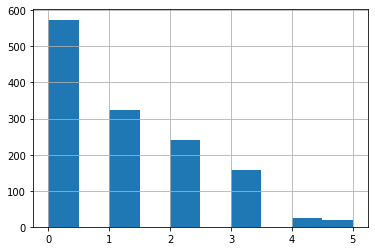

In [13]:
data.children.hist()

Как видно из гистограммы большинство не имеет детей. Максимальное количество детей - 5. 

Столбец smoker (курильщик) - категориальные данные, принимают значение либо yes - курит, либо no - не курит. Имеет биномиальное рапределение.

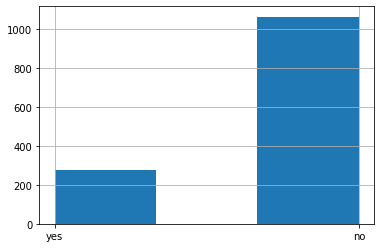

In [14]:
data.smoker.hist(bins=3)

Как видно из гистограммы, большинство представленных людей в датасете не курит.

In [15]:
len(data[data['smoker']=='no']), len(data[data['smoker']== 'yes'])

(1064, 274)

Столбец region (регион) - категориальные данные, принимает четыре значения southwest, southeast, northwest, northeast.

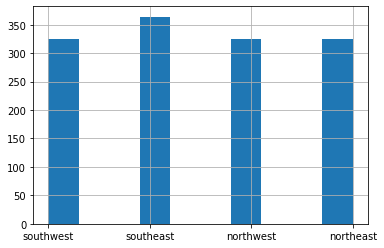

In [16]:
data.region.hist()

В датасете представлено примерно одинаковое количество людей из всех регионов.

Столбец charges(стоимость страховки) - непрерывная велчина.

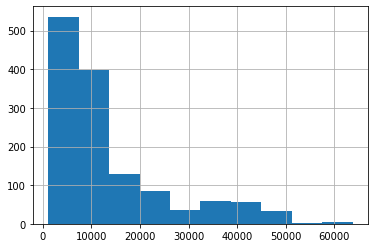

In [17]:
data.charges.hist()

In [18]:
from statsmodels.stats.diagnostic import lilliefors
# If the pvalue is lower than some threshold, e.g. 0.05, 
# then we can reject the Null hypothesis that the sample comes from a exponential distribution.
ksstat, pvalue = lilliefors(data['charges'], dist='exp')
print('pvalue: ', pvalue)
alpha = 0.05
if pvalue < alpha:
    print('не экспоненциальное распределение')
else:
    print('экспоненциальное распределение для alpha = ', alpha)

pvalue:  0.01
не экспоненциальное распределение


Сделаем из всех категориальных переменных бинарные (этот датасет будет нужен для построения модели линейной регрессии):

In [89]:
df = pd.get_dummies(data)
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


Столбцы sex_female, smoker_no излишни, удалим их:

In [90]:
df.drop(['sex_female', 'smoker_no'], axis='columns', inplace=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


Для удобства переименуем столбцы sex_male, smoker_yes:

In [91]:
df.rename(columns={'sex_male': 'sex', 'smoker_yes': 'smoker'}, inplace=True)
df.head()

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


Посмотрим основные статистические характеристики:

In [25]:
df.describe()

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.204783,0.242152,0.242900,0.272048,0.242900
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694,0.428546,0.428995,0.445181,0.428995
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Средний возраст людей в нашем датасете 32 года, разброс возрастов от 18 до 64 лет. Средний индекс массы тела 30.7, в среднем у каждого человека по одному ребенку. Разброс стоимостей мед страховок - от 1121 до 63770.

In [26]:
statistics.mode(data['bmi'])

32.3

Чаще всего встречается индекс массы тела, равный 32.3

In [27]:
statistics.mode(data['age'])

18

Как было видно ранее из гистограммы, самый часто встречающийся возраст в выборке - 18 лет

In [28]:
statistics.mode(data['children'])

0

Как было также видно из соотвтествующей гистограммы, самое часто встречающееся количество детей - 0.

Из полученной информации можно сделать предположение о том, что количество детей тем больше, чем возраст челоека ( в нашем датасете много молодых у людей, у которых нет детей).
Визуализируем зависимость количества детей от возраста:

Text(0, 0.5, 'количество детей')

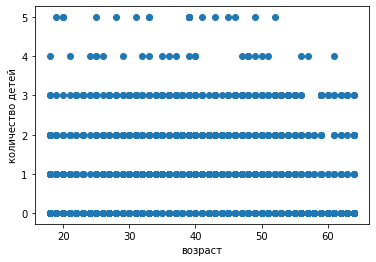

In [29]:
age = data['age']
children = data['children'] 
plt.scatter(age, children)
plt.xlabel('возраст')
plt.ylabel('количество детей')

Из такого графика трудно понять, есть ли какая то зависимость между количеством детей и возрастом. Можно лишь говорить о том, что и у молодых людей есть дети, причем больше одного. Посчитаем, сколько детей в сумме приходится на каждый возраст. Для этого сначала построим сводную таблицу, где строки - это возраст, а столбцы - количество детей.

In [30]:
pivot_data = data.pivot_table(index = 'age', columns = 'children', values = 'charges', 
                              aggfunc = 'count', fill_value = 0, margins= True).reset_index()
pivot_data

children,age,0,1,2,3,4,5,All
0,18,51,9,6,2,1,0,69
1,19,50,11,5,1,0,1,68
2,20,17,6,3,1,0,2,29
3,21,16,5,5,1,1,0,28
4,22,18,4,2,4,0,0,28
5,23,13,6,5,4,0,0,28
6,24,23,1,1,2,1,0,28
7,25,12,6,4,3,2,1,28
8,26,10,9,7,1,1,0,28
9,27,14,6,3,5,0,0,28


Удалим последнюю строку с итогами. Она не нужна и будет мешать вычислениям:

In [31]:
pivot_data = pivot_data.loc[pivot_data.age != 'All']
pivot_data.tail()

children,age,0,1,2,3,4,5,All
42,60,19,2,0,2,0,0,23
43,61,15,3,2,2,1,0,23
44,62,16,3,2,2,0,0,23
45,63,17,2,1,3,0,0,23
46,64,13,3,4,2,0,0,22


Для удосбтва переименуем столбцы и посчитаем сколько в сумме детей приходится на каждый возраст:

In [32]:
pivot_data.rename(columns={'children': 'index', 0: 'children_0', 1:'Children_1', 2: 'children_2', 3: 'children_3',
                          4: 'children_4', 5:'children_5'}, inplace=True)
pivot_data['children_sum'] = pivot_data['All'] - pivot_data['children_0']
pivot_data.head()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


children,age,children_0,Children_1,children_2,children_3,children_4,children_5,All,children_sum
0,18,51,9,6,2,1,0,69,18
1,19,50,11,5,1,0,1,68,18
2,20,17,6,3,1,0,2,29,12
3,21,16,5,5,1,1,0,28,12
4,22,18,4,2,4,0,0,28,10


Сравнивать просто количество детей в разных возрастных группах в нашем случае некорректно, так как возрастные группы в нашем датасете несбалансированы, поэтому посчитаем количество детей на одного человека для каждого возраста.

In [33]:
data_count = data.groupby('age').count()['sex'].reset_index()
data_count.rename(columns={'sex': 'count_of_people'}, inplace=True)
data_count.head()

,age,count_of_people
0,18,69
1,19,68
2,20,29
3,21,28
4,22,28


In [34]:
data_children = pd.merge(pivot_data, data_count, on = 'age', how = 'left')
data_children.head()

,age,children_0,Children_1,children_2,children_3,children_4,children_5,All,children_sum,count_of_people
0,18,51,9,6,2,1,0,69,18,69
1,19,50,11,5,1,0,1,68,18,68
2,20,17,6,3,1,0,2,29,12,29
3,21,16,5,5,1,1,0,28,12,28
4,22,18,4,2,4,0,0,28,10,28


In [35]:
data_children['children_per_person'] = data_children['children_sum']/data_children['count_of_people']
data_children.head()


,age,children_0,Children_1,children_2,children_3,children_4,children_5,All,children_sum,count_of_people,children_per_person
0,18,51,9,6,2,1,0,69,18,69,0.260870
1,19,50,11,5,1,0,1,68,18,68,0.264706
2,20,17,6,3,1,0,2,29,12,29,0.413793
3,21,16,5,5,1,1,0,28,12,28,0.428571
4,22,18,4,2,4,0,0,28,10,28,0.357143


Text(0, 0.5, 'количество детей на человека')

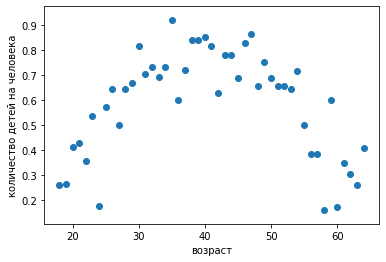

In [36]:
age = data_children['age']
children = data_children['children_per_person'] 
plt.scatter(age, children)
plt.xlabel('возраст')
plt.ylabel('количество детей на человека')


Получили интересную нелинейную зависимость количества детей от возраста. Видим, что эта зависимость напоминает параболу с максимумом в районе 40 лет.

Посмотрим, зависит ли количество детей на человека от пола. 

In [37]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Посчитаем количество мужчин и женщин в разрезе возраста:

In [38]:
data_sex = data.groupby(['age', 'sex']).count()['children']
data_sex.head()


age  sex   
18   female    33
     male      36
19   female    33
     male      35
20   female    14
Name: children, dtype: int64

In [39]:
data_sex = data_sex.unstack()
data_sex.rename(columns={'female': 'count_female', 'male': 'count_male'}, inplace=True)
data_sex.head()

sex,count_female,count_male
age,,
18,33,36
19,33,35
20,14,15
21,13,15
22,13,15


Посчитаем количество детей, приходящихся на мужчин и женщин в разрезе возраста:

In [40]:
pivot_children_by_sex = data.pivot_table(index = 'age', columns = 'sex', values = 'children', 
                              aggfunc = 'sum', fill_value = 0)
pivot_children_by_sex.head()

sex,female,male
age,,
18,13,18
19,20,9
20,8,17
21,10,12
22,8,12


In [41]:
pivot_children_by_sex.rename(columns={'female': 'count_children_of_female','male': 'count_children_of_male'}, inplace=True)
pivot_children_by_sex.head()

sex,count_children_of_female,count_children_of_male
age,,
18,13,18
19,20,9
20,8,17
21,10,12
22,8,12


Посчитаем количество детей, приходящихся на одного мужчину и на одну женщину в разрезе возраста:

In [42]:
data_children_by_sex = pd.merge(data_sex, pivot_children_by_sex, on = 'age', how = 'left')
data_children_by_sex.head()

sex,count_female,count_male,count_children_of_female,count_children_of_male
age,,,,
18,33,36,13,18
19,33,35,20,9
20,14,15,8,17
21,13,15,10,12
22,13,15,8,12


In [43]:
data_children_by_sex['children_per_female'] = data_children_by_sex['count_children_of_female']/data_children_by_sex['count_female']
data_children_by_sex['children_per_male'] = data_children_by_sex['count_children_of_male']/data_children_by_sex['count_male']
data_children_by_sex.head()

sex,count_female,count_male,count_children_of_female,count_children_of_male,children_per_female,children_per_male
age,,,,,,
18,33,36,13,18,0.393939,0.500000
19,33,35,20,9,0.606061,0.257143
20,14,15,8,17,0.571429,1.133333
21,13,15,10,12,0.769231,0.800000
22,13,15,8,12,0.615385,0.800000


In [44]:
data_children_by_sex = data_children_by_sex.loc[:,['children_per_female','children_per_male']]
data_children_by_sex.head()

sex,children_per_female,children_per_male
age,,
18,0.393939,0.500000
19,0.606061,0.257143
20,0.571429,1.133333
21,0.769231,0.800000
22,0.615385,0.800000


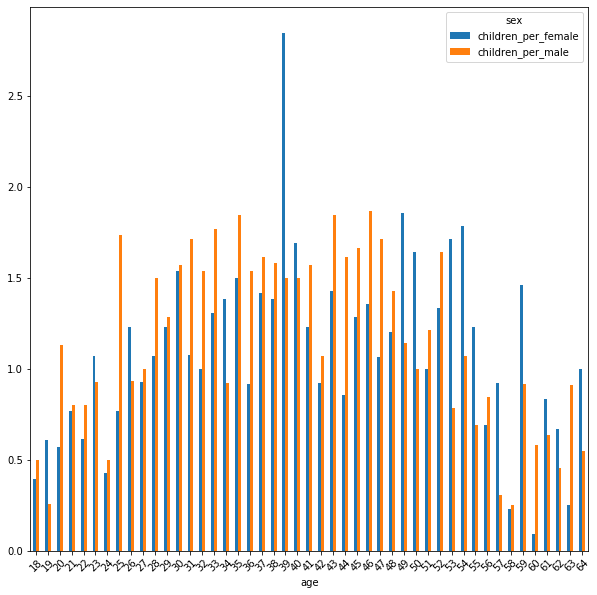

In [45]:
data_children_by_sex.plot(kind = 'bar', rot = 45, figsize=(10,10))

Из графика можно заметить, что в 40 лет количество детей на одну женщину в 2 раза больше, чем на одного мужчину. 

Посмотрим, как изменяется разница между количеством детей на одну женщину и количеством детей на одного мужчину с возрастом:

In [46]:
data_children_by_sex['dif'] = data_children_by_sex['children_per_female'] - data_children_by_sex['children_per_male']

In [47]:
data_dif = data_children_by_sex['dif']
data_dif.head()

age
18   -0.106061
19    0.348918
20   -0.561905
21   -0.030769
22   -0.184615
Name: dif, dtype: float64

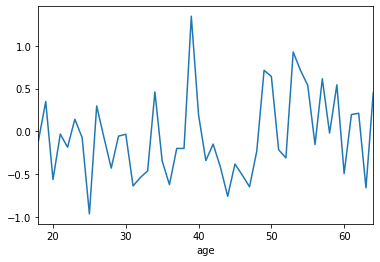

In [48]:
data_dif.plot()

In [49]:
data_children_by_sex['dif'].sum()

-2.437878787878787

Таким образом получили, что количество детей на одного мужчину больше, чем на одну женщину

Исследуем зависимость bmi от пола, возраста и курения. Сначала построим зависимость  bmi от возраста:

Text(0, 0.5, 'индекс массы тела')

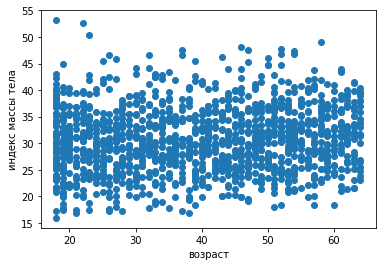

In [50]:
age = data['age']
bmi = data['bmi'] 
plt.scatter(age, bmi)
plt.xlabel('возраст')
plt.ylabel('индекс массы тела')


Видим, что зависимости индекса массы тела от возраста не прослеживается. Рассмотрим несколько гипотез.


### Гипотеза 1: Курящие люди имеют такой же bmi,как некурящие (двухвыборочный t-критерий)

In [51]:
smokers = data[data['smoker'] == 'yes']['bmi']
healthy = data[data['smoker'] == 'no']['bmi']


In [52]:
sts.shapiro(data['bmi'])


(0.9938876032829285, 2.609841976664029e-05)

In [53]:
len(smokers), len(healthy)


(274, 1064)

In [54]:
smokers.mean(), healthy.mean()


(30.708448905109503, 30.651795112781922)

In [55]:
healthy = healthy.sample(n = 274)


In [56]:
statistics.variance(smokers), statistics.variance(healthy)


(39.92526177943103, 35.52626922709286)

In [57]:
sts.ttest_ind(smokers, healthy, equal_var=True)


Ttest_indResult(statistic=0.18569574463974817, pvalue=0.8527523296085493)

Так как p-value > 0,05, то не можем отвергнуть нулевую гипотезу о том, что курящие и некурящие люди имеют одинаковый индекс массы тела. 

### Гипотеза 2: Мужчины имеют такой же bmi,как и женщины (двухвыборочный t-критерий)

In [58]:
male = data[data['sex'] == 'male']['bmi']
female = data[data['sex'] == 'female']['bmi']


In [59]:
len(male), len(female)


(676, 662)

In [60]:
male.mean(), female.mean()


(30.943128698224832, 30.377749244713023)

In [61]:
statistics.variance(male), statistics.variance(female)

(37.704937270819634, 36.55439515336554)

In [62]:
sts.ttest_ind(smokers, healthy, equal_var=True)

Ttest_indResult(statistic=0.18569574463974817, pvalue=0.8527523296085493)

Так как p-value > 0,05, то можем сделать вывод, что наша гипотеза верна и нет статистического отличия между bmi женщин и мужчин.

Рассмотрим распределение курильщиков по регионам:

In [63]:
smoker = data[data['smoker'] == 'yes']
smoker.groupby('region').count()['charges']


region
northeast    67
northwest    58
southeast    91
southwest    58
Name: charges, dtype: int64

In [64]:
data.groupby('region').count()['charges']

region
northeast    324
northwest    325
southeast    364
southwest    325
Name: charges, dtype: int64

In [65]:
58/325


0.17846153846153845

In [66]:
91/364


0.25

In [67]:
67/324


0.20679012345679013

### Гипотеза 3: В регионе southeast такое же количество курящих людей, как и везде

Сравним 2 группы людей, курильщиков из southeast и курильщиков из остальных регионов

In [68]:
region_se = data[data['region'] == 'southeast']['smoker']
other = data[data['region'] != 'southeast']['smoker']


Используем критерий Манна-Уитни для того чтобы понять, есть ли статистическое различие между количеством курящих людей в регионе southeast и количеством курящих людей в других регионах:

In [69]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(region_se, other)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')
    

stat=166257.000, p=0.006
Probably different distributions


Тест показал, что статистически различия существуют, а значит можно говорить о том, что курящих людей в регионе southeast больше.

### Построим модель линейной регрессии

Для этого будем работать с преобразованным датасетом df, где все категориальные данные приведены к бинарному виду.

In [70]:
df.head()


,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,0,1
1,18,33.770,1,1725.55230,1,0,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0,0
4,32,28.880,0,3866.85520,1,0,0,1,0,0


In [71]:
corr_matrix = df.corr()
corr_matrix


,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,0.002475,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,-0.022808,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,0.006349,-0.039905,0.073982,-0.043210
sex,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.002425,-0.011156,0.017117,-0.004184
smoker,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,0.002811,-0.036945,0.068498,-0.036945
region_northeast,0.002475,-0.138156,-0.022808,0.006349,-0.002425,0.002811,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320177,-0.320829,-0.346265,1.000000


Как видно из матрицы корреляций, самая высокая корреляция стоимости страховки(charges) с показателем smoker.

Построим график pairplot в разрезе показателя smoker:

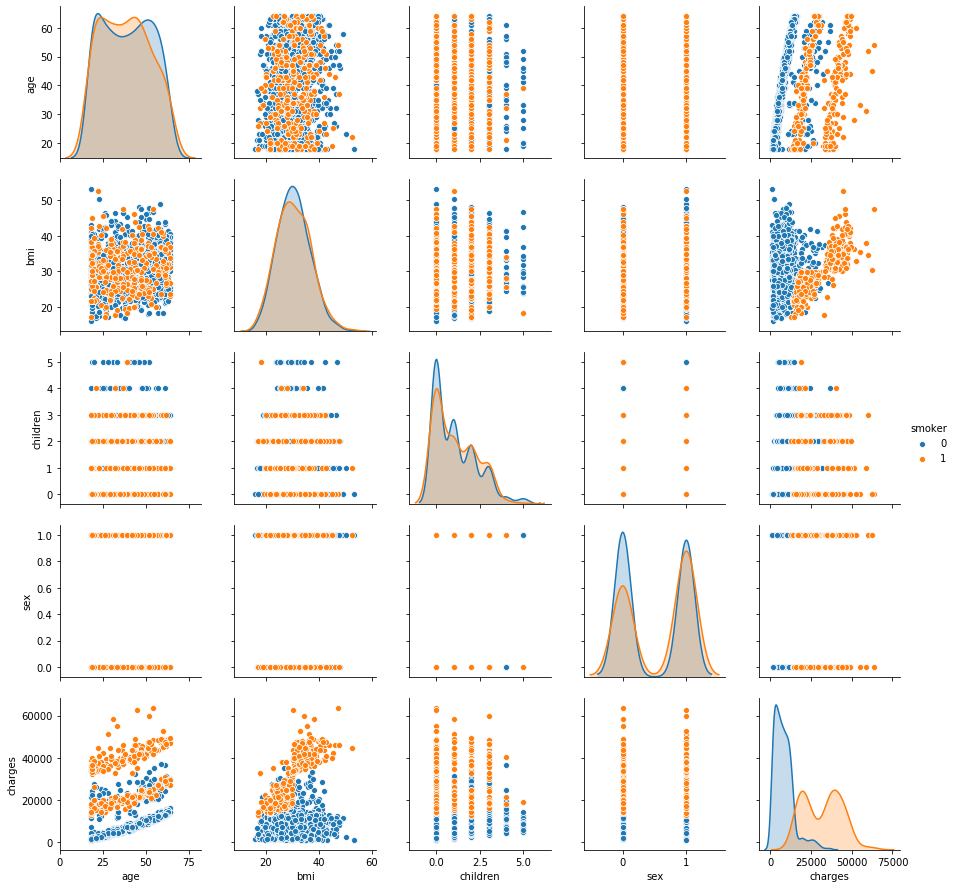

In [72]:
sns.pairplot(df, vars=['age','bmi','children', 'sex', 'charges'], hue = 'smoker', kind="scatter")


Сначала построим модель линейной регрессии "в лоб", используя все предикторы:

In [73]:
df.columns


Index(['age', 'bmi', 'children', 'charges', 'sex', 'smoker',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [74]:
x = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']]
y = df['charges']


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression


Делим данные на тренировочные и тестовые:

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


In [77]:
len(x_train), len(x_test), len(data)


(936, 402, 1338)

Применяем модель линейной регрессии:

In [78]:
model = LinearRegression()
model.fit(x_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
predict_train_y = model.predict(x_train)
predict_test_y = model.predict(x_test)

Проведем оценку полученной модели. Для этого начала визуализируем корреляциооную зависимость предсказанных данных с данными из датасета (тренировочных и тестовых):

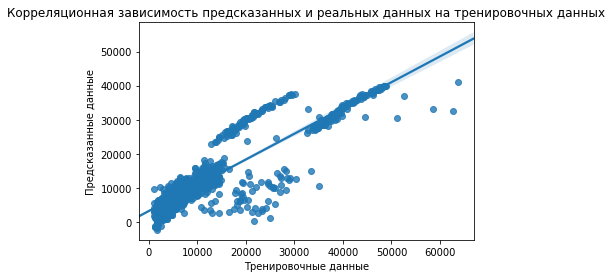

In [80]:
sns.regplot(x= y_train, y=predict_train_y, data=data, fit_reg=True)
plt.xlabel('Тренировочные данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тренировочных данных')
plt.grid(False)
plt.show()

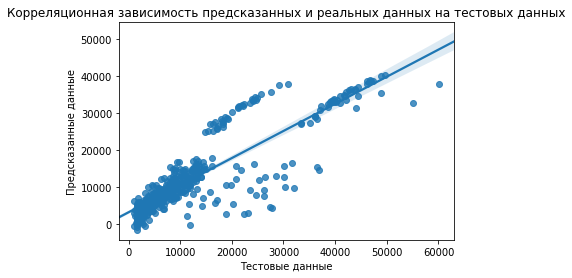

In [81]:
sns.regplot(x= y_test, y=predict_test_y, data=data, fit_reg=True)
plt.xlabel('Тестовые данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тестовых данных')
plt.grid(False)
plt.show()

Видим, что модель довольно неплохо справилась с предсказанием, однако разброс точек не постоянен, есть области, где разброс достаточно велик.

Оценим среднеквадратичную ошибку и коэффцициент детерминации:

In [118]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

Среднеквадратичная ошибка модели:

In [92]:
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, predict_train_y),
        mean_squared_error(y_test, predict_test_y)))

MSE train: 35725057.740, test: 39002661.053


Коэффициент детерминации:

In [93]:
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, predict_train_y),
        r2_score(y_test, predict_test_y)))


R^2 train: 0.739, test: 0.768


Абсолютная средняя ошибка:

In [ ]:
print('mean_absolute_error train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, predict_train_y),
        mean_absolute_error(y_test, predict_test_y)))

Получили довольно высокий коэффициент детерминации, что говорит о том, что модель примерно на 70-75% объясняет зависимость стоимости страховки от всех предикторов, которые мы использовали в модели.

Качество полученной модели также можно диагностировать с помощью связи между остатками модели и предсказаными значениями.С помощью такой визуализации можно увидеть нелинейность и выбросы, проверить нормальность распределения ошибки. 

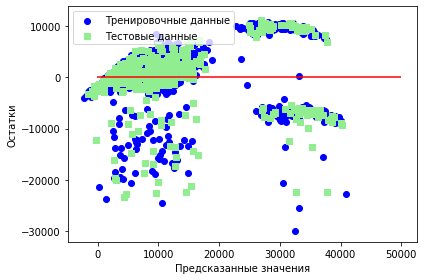

In [82]:
plt.scatter(predict_train_y,  predict_train_y - y_train,
            c='blue', marker='o', label='Тренировочные данные')
plt.scatter(predict_test_y,  predict_test_y - y_test,
            c='lightgreen', marker='s', label='Тестовые данные')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50000, color='red')
#plt.xlim([-10, 50])
plt.tight_layout()

Из полученного графика видно, что остатки распределены не нормально и неравномерно, есть выбросы в минус (действительно у нас много точек под регресионной прямой, это видно также на корреляционном графике предсказзанных и реальных данных).

Предскажем с помощью нашей модели стоимость страховки и сравним полученную стоимость с реальными стоимостями из датасета:

In [83]:
df[(df['age'] == 45) & (df['smoker'] == 1)]

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
85,45,22.895,2,21098.55405,1,1,0,1,0,0
327,45,36.480,2,42760.50220,1,1,0,1,0,0
917,45,22.895,0,35069.37452,1,1,1,0,0,0
1037,45,30.495,1,39725.51805,0,1,0,1,0,0
1300,45,30.360,0,62592.87309,1,1,0,0,1,0


In [87]:
# Создадим человека, с такими же показателями, как строка с индексом 917 и посмотрим, что предскажет модель
df_new = {'age':45, 'sex':1, 'bmi':22.895, 'children':0, 'smoker':1, 'region_northeast':0, 'region_northwest':1, 
      'region_southeast':0, 'region_southwest':0}
index = [1]
df_new= pd.DataFrame(df,index)
df_new

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
1,45,1,22.895,0,1,0,1,0,0


In [88]:
prediction = model.predict(df_new)
print("Predicted medical Insurance cost is : ",prediction)

Predicted medical Insurance cost is :  [31021.39212316]


Видим, что модель неплохо справилась с предсказанием.

### Попробуем улучшить нашу модель (уменьшить разброс точек на корреляционной прямой зависимости предсказанных и реальных значений)

Для этого посмотрим, как будет выглядеть зависимость параметра charges от предикторов в разрезе курящих и некурящих людей:

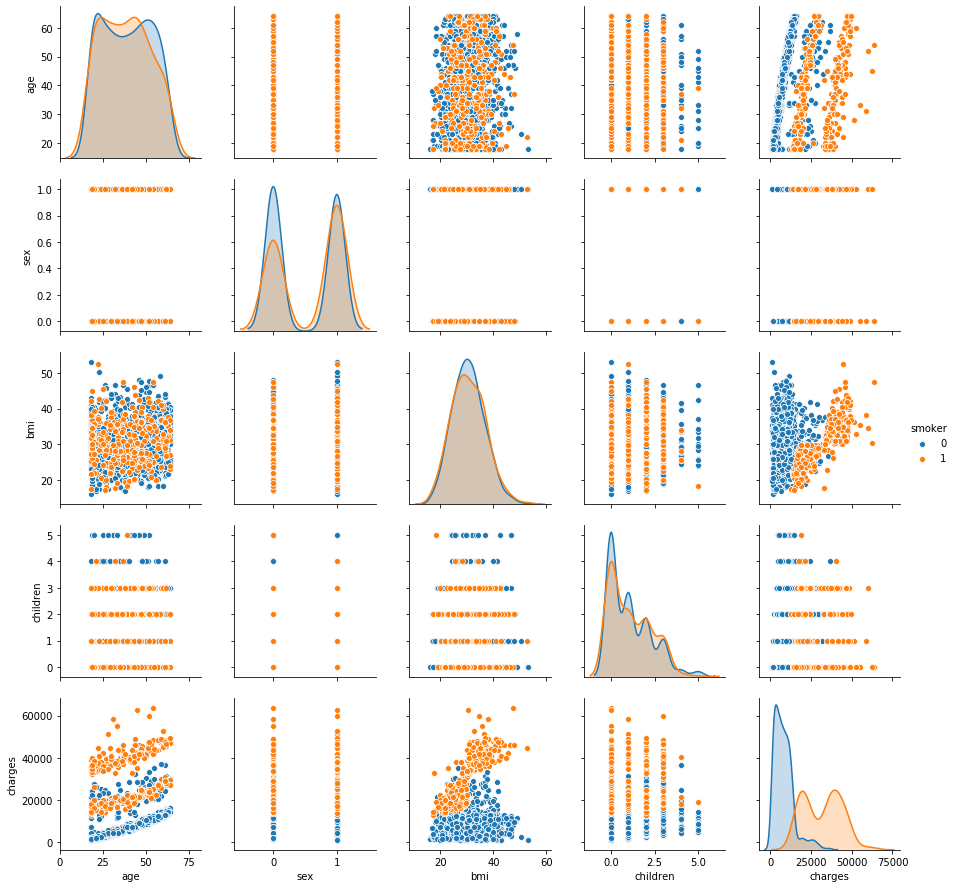

In [92]:
sns.pairplot(df, vars=['age', 'sex', 'bmi', 'children', 'charges'], hue = 'smoker', kind="scatter")

Сначала рассмотрим некурящих:

In [93]:
healthy_data = df[df['smoker'] == 0]

In [94]:
corr_matrix = healthy_data.corr()
corr_matrix

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.122638,0.033395,0.627947,-0.022338,NaN,0.006079,-0.008914,-0.029687,0.032819
bmi,0.122638,1.000000,0.019208,0.084037,0.019119,NaN,-0.123297,-0.137901,0.271417,-0.013792
children,0.033395,0.019208,1.000000,0.138929,0.002090,NaN,-0.020177,0.014083,-0.011721,0.017644
charges,0.627947,0.084037,0.138929,1.000000,-0.056320,NaN,0.068882,0.011806,-0.039426,-0.040092
sex,-0.022338,0.019119,0.002090,-0.056320,1.000000,NaN,0.000541,0.009820,0.005807,-0.016204
smoker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_northeast,0.006079,-0.123297,-0.020177,0.068882,0.000541,NaN,1.000000,-0.326630,-0.331530,-0.326630
region_northwest,-0.008914,-0.137901,0.014083,0.011806,0.009820,NaN,-0.326630,1.000000,-0.340032,-0.335006
region_southeast,-0.029687,0.271417,-0.011721,-0.039426,0.005807,NaN,-0.331530,-0.340032,1.000000,-0.340032
region_southwest,0.032819,-0.013792,0.017644,-0.040092,-0.016204,NaN,-0.326630,-0.335006,-0.340032,1.000000


In [95]:
len(healthy_data)

1064

In [96]:
healthy_data.describe()

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.0,1064.000000,1064.000000,1064.000000,1064.000000
mean,39.385338,30.651795,1.090226,8434.268298,0.485902,0.0,0.241541,0.250940,0.256579,0.250940
std,14.083410,6.043111,1.218136,5993.781819,0.500036,0.0,0.428219,0.433758,0.436950,0.433758
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,26.750000,26.315000,0.000000,3986.438700,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,40.000000,30.352500,1.000000,7345.405300,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,52.000000,34.430000,2.000000,11362.887050,1.000000,0.0,0.000000,1.000000,1.000000,1.000000
max,64.000000,53.130000,5.000000,36910.608030,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


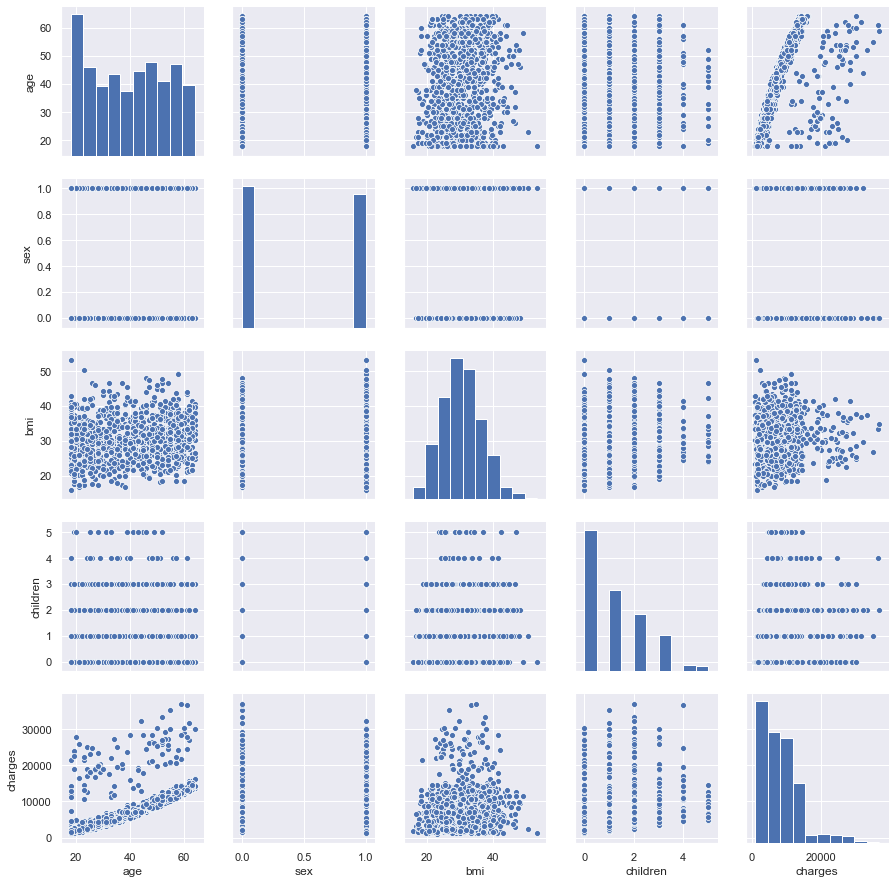

In [765]:
sns.pairplot(healthy_data, vars=['age','sex', 'bmi', 'children', 'charges'], kind="scatter")

Из матрицы корреляций и из графика видно, что лучше всего charges коррелирует с age. Линейную зависимость с другими параметрами увидеть трудно, поэтому в модели линейной регрессии будем учитывать только age.

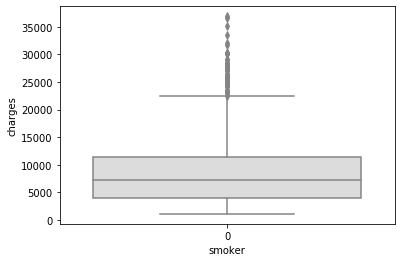

In [106]:
sns.boxplot(x='smoker', y='charges', data=healthy_data, palette="coolwarm")


Видно, что есть выбросы  charges при высоких значениях. В нашей модели ограничимся примерно 85% процентилем:

In [134]:
healthy_data.charges.quantile(.85)

13031.6790225

In [135]:
healthy_data_low = healthy_data[healthy_data['charges'] < 13031.6790225]

In [136]:
len(healthy_data_low)

904

Построим модель линейной регрессии:

In [137]:
x = healthy_data_low[['age']]

y = healthy_data_low['charges']

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [139]:
model_healthy = LinearRegression()
model_healthy.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [140]:
predict_train_y = model_healthy.predict(x_train)
predict_test_y = model_healthy.predict(x_test)

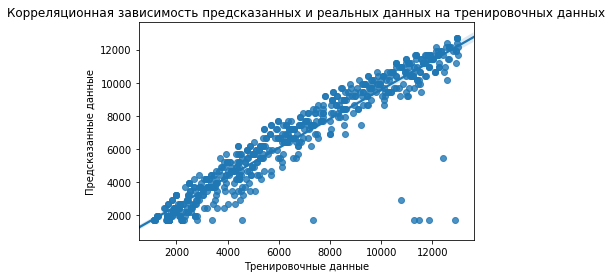

In [141]:
sns.regplot(x= y_train, y=predict_train_y, data=data, fit_reg=True)
plt.xlabel('Тренировочные данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тренировочных данных')
plt.grid(False)
plt.show()

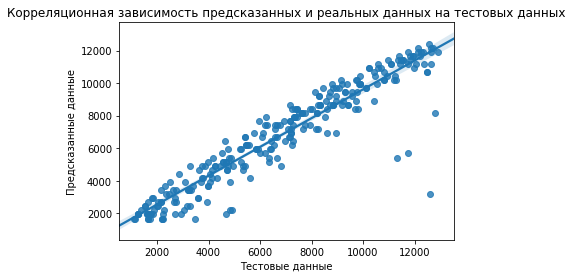

In [142]:
sns.regplot(x= y_test, y=predict_test_y, data=data, fit_reg=True)
plt.xlabel('Тестовые данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тестовых данных')
plt.grid(False)
plt.show()

Видим, что выбросы остались, но их стало значительно меньше.

In [143]:
print('MSE train: {:.3f}, test: {:.3f}'.format(
        mean_squared_error(y_train, predict_train_y),
        mean_squared_error(y_test, predict_test_y)))

MSE train: 1485157.972, test: 1295179.434


In [144]:
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, predict_train_y),
        r2_score(y_test, predict_test_y)))

R^2 train: 0.880, test: 0.883


In [145]:
print('mean_absolute_error train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, predict_train_y),
        mean_absolute_error(y_test, predict_test_y)))

mean_absolute_error train: 713.632, test: 713.295


Коэффициент детерминации увеличился, абсолютная средняя ошибка уменьшилась.

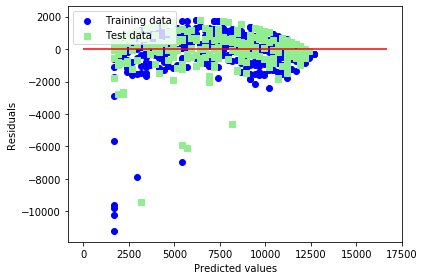

In [146]:
plt.scatter(predict_train_y,  predict_train_y - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(predict_test_y,  predict_test_y - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=16700, color='red')
#plt.xlim([-10, 50])
plt.tight_layout()

Остатки модели по-прежнему распределены не нормально, присутствуют выбросы в отрицательную сторону.

### Таким образом, можно сделать вывод, что модель для некурящих людей хорошо работает в случае небольших charges. Чем больше charges (выше значения 75% квартиля), тем прогностическая сила модели хуже.

Теперь построим отдельно модель для курящих:

In [165]:
smokers_data = df[df['smoker'] == 1]

In [166]:
len(smokers_data)

274

In [167]:
corr_matrix = smokers_data.corr()
corr_matrix

,age,bmi,children,charges,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.059674,0.081183,0.368224,-0.005758,NaN,-0.011290,0.030313,0.061987,-0.089901
bmi,0.059674,1.000000,-0.012619,0.806481,0.148350,NaN,-0.193326,-0.128827,0.267021,0.024379
children,0.081183,-0.012619,1.000000,0.035945,0.076907,NaN,-0.033675,0.073008,-0.069078,0.042066
charges,0.368224,0.806481,0.035945,1.000000,0.101226,NaN,-0.117370,-0.083583,0.171069,0.009843
sex,-0.005758,0.148350,0.076907,0.101226,1.000000,NaN,-0.015134,-0.084307,0.034441,0.060521
smoker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_northeast,-0.011290,-0.193326,-0.033675,-0.117370,-0.015134,NaN,1.000000,-0.294808,-0.401187,-0.294808
region_northwest,0.030313,-0.128827,0.073008,-0.083583,-0.084307,NaN,-0.294808,1.000000,-0.365412,-0.268519
region_southeast,0.061987,0.267021,-0.069078,0.171069,0.034441,NaN,-0.401187,-0.365412,1.000000,-0.365412
region_southwest,-0.089901,0.024379,0.042066,0.009843,0.060521,NaN,-0.294808,-0.268519,-0.365412,1.000000


Из матрицы корреляций видно, что charges лучше всего коррелирует с bmi. Включим такде в модель age, кэффициент коррялции которого 0.4.

In [168]:
x = smokers_data[['age', 'bmi']]
y = smokers_data['charges']

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [170]:
model_smokers = LinearRegression()
model_smokers.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [171]:
predict_train_y = model_smokers.predict(x_train)
predict_test_y = model_smokers.predict(x_test)

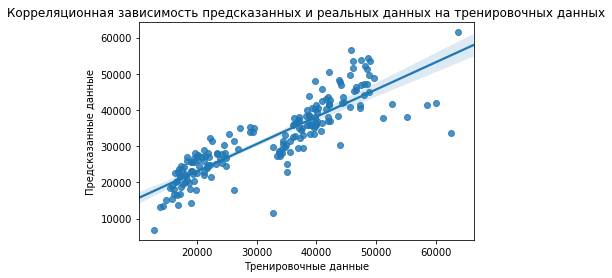

In [172]:
sns.regplot(x= y_train, y=predict_train_y, data=data, fit_reg=True)
plt.xlabel('Тренировочные данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тренировочных данных')
plt.grid(False)
plt.show()

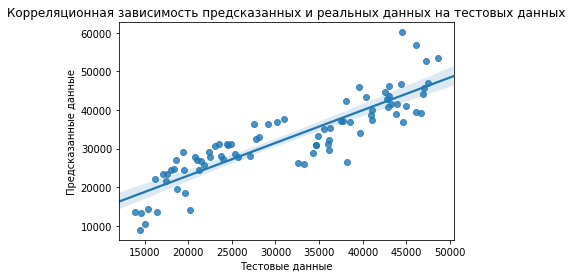

In [173]:
sns.regplot(x= y_test, y=predict_test_y, data=data, fit_reg=True)
plt.xlabel('Тестовые данные')
plt.ylabel('Предсказанные данные')
plt.title('Корреляционная зависимость предсказанных и реальных данных на тестовых данных')
plt.grid(False)
plt.show()

Видим, что разброс точек получился более равномерным, выбросов стало намного меньше.

In [174]:
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(y_train, predict_train_y),
        r2_score(y_test, predict_test_y)))

R^2 train: 0.753, test: 0.746


In [175]:
print('mean_absolute_error train: {:.3f}, test: {:.3f}'.format(
        mean_absolute_error(y_train, predict_train_y),
        mean_absolute_error(y_test, predict_test_y)))

mean_absolute_error train: 4424.542, test: 4554.222


Коэффициент детерминации стал немного выше, если сравнивать его с общей моделью, где нет разделения на курящих и некурящих.

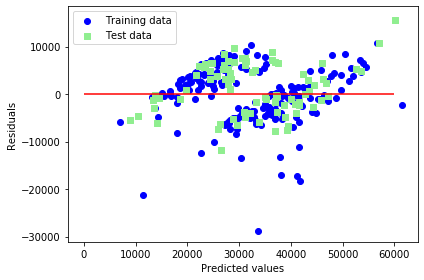

In [176]:
plt.scatter(predict_train_y,  predict_train_y - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(predict_test_y,  predict_test_y - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=60000, color='red')
#plt.xlim([-10, 50])
plt.tight_layout()

Распределение остатков модели также стало лучше (меньше выбросов, разброс точек уменьшелся).

### Таким образом, можно сделать вывод о том, что нам удалось увеличить качество предсказательной модели, рассматривая отдельно курящих и некурящих людей. Обе модели (общая и с разделением на курящих/некурящих) плохо справляются с предсказаниями больших стоимостей страховок. 